Now, the work done on the kaggle dataset is all very well. However, that dataset bears the same resemblence to data in the real world as a perfectly posed and touched up shot of a supermodel does to a cellphone pic of a random person on the street. Real data isn't perfectly organinzed and is quite often a mess. In the spirit of that, I've chosen to use the API for the Hirez game Smite to do this project. 

The question I've chosen to ask is the following: Which of the playable characters (gods) is the best? By best, I mean the god with the highest (at least in the data I am able to pull) win rate. Since the data is sorted by queue (which game mode was played), I will be further narrowing my question to which god is best in Joust mode. Code to access the API, pull out this data and get the answer to this question follows below.

First, we import what we need and set some options to make sure things come out the way we want.

In [2]:
from pytz import timezone
from datetime import datetime
import os
import hashlib
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
#This is a jupyter notebook command that will make all graphs appear automatically, no need to use print()
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#Without the pd.set above, we will get some weird formats for our match id numbers if we save and then load them back in.


Now we set up our functions

In [3]:

def get_time_string():
    """
    As a part of the signature and a part of every call to the API we need the current UTC time in a specific format
    which this function creates for us.
    """
    current_time = datetime.now(timezone('UTC'))
    current_time = current_time.strftime("%Y%m%d%H%M%S")
    return current_time

    
def signature(method_name):
    """
    Creates the signature, which takes a string composed of DevId, method call, Auth Key and the date and hashes it. 
    This is required for every call to the API. Note: This function will not work unless the DevId and Auth Key placeholders
    are replaced by real ones, which must be granted by Hirez.
    
    :param method_name: String that consists of the particular type of call you are attempting.
    """
    working_string = "DevId" + method_name + "Auth Key" + get_time_string()
    result = hashlib.md5(working_string.encode())
    return(result.hexdigest())
    
   
def create_session():
    """
    Creates a session with the Smite API. Must be done before any queries are made. Note: This function will not work unless
    the DevId placeholder is replaced by a real DevId.
    """
    copy_string = "https://api.smitegame.com/smiteapi.svc/createsessionJson/DevId/"
    copy_string += str(signature("createsession")) + "/" + get_time_string()
    return copy_string


def get_gods():
    """
    Pulls the data on the various gods from the Smite API. Note: This function will not work unless the DevId placeholder 
    is replaced by a real DevId.
    """
    copy_string = "https://api.smitegame.com/smiteapi.svc/getgodsJson/DevId/"
    copy_string += str(signature("getgods")) + "/" + session_deets['session_id'] + "/" + get_time_string() + "/1"
    return copy_string


def get_match_details(match_id):
    """
    Pulls the data on specific match from the Smite API. Note: This function will not work unless the DevId placeholder 
    is replaced by a real DevId.
    
    :param match_id: Int that specifies which match you wish to know about. May be acquired in game from a player's match
    history or by other calls.
    """
    copy_string = "https://api.smitegame.com/smiteapi.svc/getmatchdetailsJson/DevId/"
    copy_string += str(signature("getmatchdetails")) + "/" + session_deets['session_id'] + "/" + get_time_string() + "/" + str(match_id)
    return copy_string


def get_match_ids(queue, date, hour):
    """
    Pulls the match ids from a specified queue during a specific ten minute interval. Note: This function will not work 
    unless the DevId placeholder is replaced by a real DevId.
    
    :param queue: Code for which queue or type of game you wish do query. Codes may be found in the Smite API documentation.
    :param date: The date of the match ids you wish to find. Must be formated as YYYYMMDD.
    "param hour" The ten minute interval during which you wish to inquire. Format is "H,MM". Valid H entries are 1-24, Valid 
    mm entries are 00, 10, 20, 30, 40, 50.
    """
    copy_string = "https://api.smitegame.com/smiteapi.svc/getmatchidsbyqueueJson/DevId/"
    copy_string += str(signature("getmatchidsbyqueue")) + "/" + session_deets['session_id'] + "/" + get_time_string() + "/" + queue + "/" + str(date) + "/" + hour
    return copy_string


def pull_date_files(date):
    """
    Pulls and saves the match details from hour 12 on the selected date. Note: The directory in the second to last line
    must be changed to match that of the location you wish the files to be saved to locally
    
    :params: date The date of the matches you wish to find information on. Must be formated as YYYYMMDD.
    """
    time_list = ["12,00", "12,10", "12,20", "12,30", "12,40", "12,50"]
    joust_id = "448"
    match_list = []
    for thing in time_list:
        match_id_answer = requests.get(get_match_ids(joust_id, date, thing))
        match_id_info = match_id_answer.json()
        for item in match_id_info:
            match_list.append(item['Match'])
        for item in match_list:
            match_id = str(item)
            match_answer = requests.get(get_match_details(item))
            match_answer = match_answer.json()
            with open(f'C:/Users/AokoK/Documents/Python Scripts/Matches/{match_id}.json', 'w') as json_file:
                json.dump(match_answer, json_file)


    

Now, we begin by creating our session

In [4]:
answer = requests.get(create_session())
print(answer.json())
#This code checks to make sure we have access to the Smite API and, if necessary, that our daily data limits have refreshed.

{'ret_msg': 'Approved', 'session_id': '7C0E60F8A15F434D97D9CE7C2CDA3E23', 'timestamp': '8/21/2022 5:49:59 PM'}


Now we need to get a sufficient sample of matches to pull data from so that we can draw our conclusions. At least 5000 is preferable. Since only a certain amount of data remains stored in the API, as we find match_ids that both exist and have match data, we will save the match data in json format locally. The following dates and times and matches were available when I pulled the data.

In [16]:
#The dates we will use reference 8/2/2022 to 8/16/2022. They are split up to avoid exceeding daily API access data caps.
#Each date_list query was run on a different day.
date_list_1 = [20220802, 20220803, 20220804]
for thing in date_list_1:
    answer = requests.get(create_session())
    #A new session created for each date will ensure our sessions (which have a time limit of 15 min) do not run out
    session_deets = answer.json()
    #Setting session_deets allows all other query functions to work properly
    pull_date_files(thing)


In [4]:
date_list_2 = [20220805, 20220806, 20220807]
for thing in date_list_2:
    answer = requests.get(create_session())
    session_deets = answer.json()
    pull_date_files(thing)

In [3]:
date_list_3 = [20220808, 20220809, 20220810] 
for thing in date_list_3:
    answer = requests.get(create_session())
    session_deets = answer.json()
    pull_date_files(thing)

In [3]:
date_list_4 = [20220811, 20220812, 20220813]
for thing in date_list_4:
    answer = requests.get(create_session())
    session_deets = answer.json()
    pull_date_files(thing)

In [6]:
date_list_5 = [20220814, 20220815, 20220816]
for thing in date_list_5:
    answer = requests.get(create_session())
    session_deets = answer.json()
    pull_date_files(thing)


Some of the match_ids will not have data and will appear as empty lists. Others will have '0's for all entries, an error which occurs if we have exceeded our daily data limit. Despite the care we have taken above, this does happen sometimes, therefore, we know that some of our data is bad. To make sure we still have enough data to work with, we run the following block of code. This gives us a list of the bad files, which I have chosen to go in immediately and clean out. If would also be possible to filter the bad data out later, in the DataFrame, by using the Pandas dropna.

In [11]:
#File directories may need to be changed to match local locations.
dir_list = os.listdir("C:/Users/AokoK/Documents/Python Scripts/Matches")
bad_files = 0
good_files = 0
bad_file_list = []
for item in dir_list:
    file_name = 'C:/Users/AokoK/Documents/Python Scripts/Matches/' + item
    with open(file_name, 'r') as f:
        data = json.load(f)
        if data == []:
            bad_files += 1
            bad_file_list.append(file_name)
        elif data[0]['Account_Level'] == 0:
                bad_file_list.append(file_name)
                bad_files += 1
        else:
                good_files += 1
print(f"The number of bad files is {bad_files}.")
print(f"The number of good files is {good_files}.")
for item in bad_file_list:
    os.remove(item)


The number of bad files is 162.
The number of good files is 5245.


We do have a number of bad files, but less than 5% of the total number and we have over 5000 good ones. We are good to proceed. Now we create our initial dataframe.

In [51]:
#File directories may need to be changed to match local locations.
dir_list = os.listdir("C:/Users/AokoK/Documents/Python Scripts/Matches")
#We need a new dir_list since the old one contains the names of now deleted files
full_frame = pd.DataFrame()
for item in dir_list:
    testing_list = []
    file_name = 'C:/Users/AokoK/Documents/Python Scripts/Matches/' + item
    with open(file_name, 'r') as f:
        data = json.load(f)
        for entry in data:
            row_list = [item[:10]]
            row_list.append(entry['Reference_Name'])
            row_list.append(entry['Win_Status'])
            testing_list.append(row_list)
        df = pd.DataFrame(data = testing_list, columns = ['Match Id', 'God Name', 'Win Status'])
        full_frame = pd.concat([full_frame, df])
full_frame


,Match Id,God Name,Win Status
0,1259334605,Danzaburou,Winner
1,1259334605,Athena,Winner
2,1259334605,Anubis,Winner
3,1259334605,Bellona,Loser
4,1259334605,Janus,Loser
...,...,...,...
1,1261794712,Anubis,Winner
2,1261794712,Horus,Winner
3,1261794712,Sobek,Loser
4,1261794712,Janus,Loser


This initial frame has all the data we need, but it needs a little tweaking to show it.

In [80]:
nf = full_frame[['God Name', "Win Status"]]
udf = nf[nf['Win Status'] == "Winner"]
sdf = udf['God Name'].value_counts()
df = pd.DataFrame(sdf)
df['Wins'] = df['God Name']
df = df['Wins']
nf = full_frame[['God Name', "Win Status"]]
udf = nf[nf['Win Status'] == "Loser"]
sdf = udf['God Name'].value_counts()
df2 = pd.DataFrame(sdf)
df2['Losses'] = df2['God Name']
df2 = df2['Losses']
full = pd.concat([df,df2],axis=1)
full['Total Games'] = full['Wins'] + full['Losses']
full['Win Rate %'] = full['Wins'] / full['Total Games']
full['Win Rate %'] = full['Win Rate %'].apply(lambda x: x*100)
full['Win Rate %'] = full['Win Rate %'].apply(lambda x: int(x))
full.reset_index(inplace=True)
full.set_index('Win Rate %', inplace=True)
full.sort_index(axis=0,ascending=False, inplace=True)
full.reset_index(inplace=True)
full.rename(columns = {'index': 'God Name'}, inplace=True)
full

,Win Rate %,God Name,Wins,Losses,Total Games
0,61,Erlang Shen,70,44,114
1,58,Ganesha,118,85,203
2,58,Sobek,119,85,204
3,57,Serqet,52,38,90
4,57,Jormungandr,111,83,194
...,...,...,...,...,...
116,39,Fafnir,48,74,122
117,39,Da Ji,45,68,113
118,38,Yemoja,42,67,109
119,36,Set,28,48,76


We have now answered our orignal question. The best (highest win rate) god in Joust (for these 15 days) is Erlang Shen. Let's take a look at some of the spread, though. As there are 121 gods in Smite, showing all of the graphically would be more than a little messy. Let's just take a look at the top.

<AxesSubplot:xlabel='God Name', ylabel='Win Rate %'>

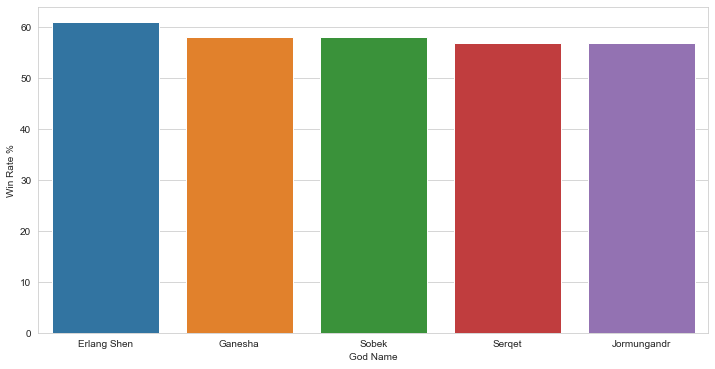

In [112]:
plt.figure(figsize=(12,6))
sns.barplot(x='God Name', y='Win Rate %', data=full.head())

All seems well, but with a glance back at our dataframe, we can tell that none of the gods with the highest win rates have very high numbers of total games. In fact, if we check which god has the highest total games played...

In [104]:
full[full['Total Games'] == full['Total Games'].max()]

,Win Rate %,God Name,Wins,Losses,Total Games
105,44,Neith,324,403,727


We can see that Neith has a total of 727 games played, nearly 7 times our win rate leader, Erlang Shen and more than 3 times any of the gods in the top five. This suggests the possibility that we don't have accurate data for these gods simply because may not have enough data for them. Let's take a look at number of matches played.


In [105]:
full['Total Games'].mean()

260.08264462809916

This is a little more encouraging. The average number of matches played is 260. All the gods in the top five are still under that number but the numbers for Ganesha (203) and Sobek (204) aren't too far from it. That suggests that these numbers may be a little more "honest" than for the rest of the top five. At the same time, we should still probably be somewhat suspicious of our conclusion as to "best" god. Let's look at the relationship between win rate and matches played.

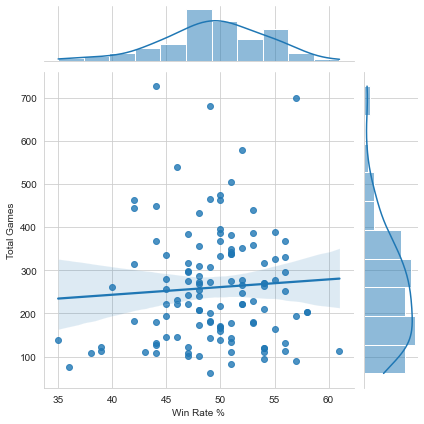

In [108]:
sns.jointplot(x='Win Rate %',y='Total Games',data=full,kind='reg')
plt.tight_layout()

We see a slight trend towards more matches leading to a higher win rate, but not really very much of one. Therefore, this suggests either there is only a slight correlation between number of matches played with a god and their win rate or that yet again, we don't have enough data to see the correlation if it exists. Fifteen days is, after all, a relatively short snapshot of time for a game that has been running for something close to eight years. Considering all of this, the conclusion that I like the most here is that I need more data. However, if I must make a conclusion based on the data I have, I think that I will say that Erland Shen is the best god in Joust. Question answered.

Or is it? Maybe your definition of "best god" has nothing to do with win rate. Winning is fun, sure, but there are other aspects that can make playing a god more or less fun. For example, let's say that you like to play a god with a lot of crowd control (CC) abilities. In particular, you like gods with stun (arguably the "hardest" form of CC) abilities. Since there are only 121 gods with four active abilities each, this is something you could do manually, but even for a fast reader, it would be pretty annoying. Let's ask the Smite API.

In [115]:
answer = requests.get(create_session())
session_deets = answer.json()
print(session_deets)

{'ret_msg': 'Approved', 'session_id': '48FB8C7534E14C2191272516DF37E5E7', 'timestamp': '8/21/2022 8:40:57 PM'}


In [120]:
gods_answer = requests.get(get_gods())
gods = gods_answer.json()
x = 0
full_list = []
for item in gods:
    ability_list = []
    for thing in item['Ability_1']['Description']['itemDescription']['rankitems']:
        if thing['description'] == "Stun Duration:":
            x += 1
            ability_list.append(item['Name'])
            ability_list.append(item['Ability1'])
            full_list.append(ability_list)
    for thing in item['Ability_2']['Description']['itemDescription']['rankitems']:
        ability_list = []
        if thing['description'] == "Stun Duration:":
            x += 1
            ability_list.append(item['Name'])
            ability_list.append(item['Ability2'])
            full_list.append(ability_list)
    for thing in item['Ability_3']['Description']['itemDescription']['rankitems']:
        ability_list = []
        if thing['description'] == "Stun Duration:":
            x += 1
            ability_list.append(item['Name'])
            ability_list.append(item['Ability3'])
            full_list.append(ability_list)
    for thing in item['Ability_4']['Description']['itemDescription']['rankitems']:
        ability_list = []
        if thing['description'] == "Stun Duration:":
            x += 1
            ability_list.append(item['Name'])
            ability_list.append(item['Ability4'])
            full_list.append(ability_list)
print(x)
stun_frame = pd.DataFrame(data = full_list, columns = ['God', "Ability"])
stun_frame
byGod = stun_frame.groupby('God').count()
byGod

31


,Ability
God,
Achilles,1
Agni,1
Ah Puch,1
Amaterasu,1
Anhur,1
Anubis,1
Aphrodite,1
Arachne,1
Cabrakan,2


There are quite a few gods that have stuns, as the table informs us, but only one god has multiple stun abilities. We don't even need to do any graphing. If your idea of the best god is the god with the most stuns, than Cabrakan is clearly the one to choose. This is a conclusion that I can state (almost) without reservation, since I have all the data in existence (at this point in time, until they add more gods) about this question. Now, there are certainly more possible definitions of "best" and more questions we could ask but that will forever be the case. For now, we have one good and one iffy conclusion and will settle for that.